In [322]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [328]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from ms2deepscore import MS2DeepScore
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem
from matchms.importing import load_from_mgf,load_from_msp
from matchms.similarity import ModifiedCosine
from src.spec2vec_comparison import Spec2VecComparison
from spec2vec import Spec2Vec
import tensorflow as tf
from ms2deepscore.models import load_model


## params

In [4]:
ls /Users/sebas/projects/data/

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
best_model_20240319_v2_512u_5_layers.ckpt
best_model_20240409_10_million_not_bining_sim_1.ckpt
best_model_20240409_1_million_not_bining_sim_1.ckpt
best_model_20240411_no_identity.ckpt
best_model_20240411_no_sim1.ckpt
drug_plus.mgf
drug_plus.pkl
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
merged_gnps_nist_20

In [5]:
data_folder= '/Users/sebas/projects/data/'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file = data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'

In [6]:
config=Config()

In [7]:
config.D_MODEL=512
config.N_LAYERS=5

In [323]:
similarity_name= 'ms2deepscore'

## open janssen data

In [9]:
all_spectrums_janssen_matchms = [s for s in load_from_mgf(janssen_path)]

2024-04-11 09:36:38,279:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,280:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,281:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,281:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,282:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,283:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,283:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,284:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,285:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,285:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,286:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-04-11 09:36:38,286:WARNING:matchms:add

In [10]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [11]:
all_spectrums_janssen_su = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

  0%|                                                                                                                                                                 | 2033/100000000 [00:01<24:35:40, 1129.41it/s]


We reached the end of the array at index 2033


## open ref data

In [12]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [13]:
all_spectrums_reference_su= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original

In [14]:
all_spectrums_gnps_matchms = [s for s in load_from_mgf(gnps_path)]

In [15]:
all_spectrums_nist_matchms=  [s for s in load_from_msp(nist_path)]

In [16]:
all_spectrums_reference_matchms = all_spectrums_gnps_matchms + all_spectrums_nist_matchms

In [17]:
#compute all the hashes from the datasets
target_hashes = [s.spectrum_hash for s in all_spectrums_reference_su]

In [18]:
matchms_hashes=[]
for s in  tqdm(all_spectrums_reference_matchms):
    matchms_hashes.append(s.spectrum_hash())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1531552/1531552 [01:13<00:00, 20911.52it/s]


In [19]:
len(target_hashes)

326386

In [20]:
len(all_spectrums_reference_matchms)

1531552

In [21]:
matchms_hashes.index(target_hashes[0])

3

In [22]:
indexes_matched = [matchms_hashes.index(t) for t in tqdm(target_hashes)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326386/326386 [28:16<00:00, 192.42it/s]


In [23]:
all_spectrums_reference = [all_spectrums_reference_matchms[index] for index in indexes_matched]

In [24]:
for i,(s_ref, s_su) in enumerate(zip(all_spectrums_reference, all_spectrums_reference_su)):
    new_metadata=s_ref.metadata.copy()
    new_metadata['smiles']=s_su.smiles
    all_spectrums_reference[i].metadata=new_metadata

## Filter spectra from Janssen

In [25]:
su_hashes = [s.spectrum_hash for s in all_spectrums_janssen_su]

In [26]:
all_spectrums_janssen = [s for s in all_spectrums_janssen_matchms if s.spectrum_hash() in su_hashes]

## Find those instances that are not in reference

In [27]:
canon_smiles_reference = [Chem.CanonSmiles(s.metadata['smiles']) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.metadata['smiles']) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [28]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(1619, 414)

In [29]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## load model

In [30]:
#encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))

In [31]:
#similarity_model =ModifiedCosine(tolerance=0.1)

In [330]:
if similarity_name=='spec2vec':
    model = gensim.models.Word2Vec.load(model_spec2vec_file)
    similarity_model= Spec2Vec(
                model=model, intensity_weighting_power=0.5, allowed_missing_percentage=100.0
            )
    PREPROCESS_SPECTRUMS=True
elif similarity_name=='modified_cosine':
    similarity_model =ModifiedCosine(tolerance=0.1)
    PREPROCESS_SPECTRUMS=True
elif similarity_name == 'ms2deepscore':
    model_ms2d = load_model(model_ms2d_file)
    similarity_model= MS2DeepScore(model_ms2d)
    PREPROCESS_SPECTRUMS=False

## Preprocessed spectrums

In [755]:
PREPROCESS_SPECTRUMS

False

In [354]:
preprocessed_all_spectrums_janssen =all_spectrums_janssen.copy()
if PREPROCESS_SPECTRUMS:
    for i,s in tqdm(enumerate(preprocessed_all_spectrums_janssen)):
        preprocessed_all_spectrums_janssen[i] = Spec2VecComparison.spectrum_processing(preprocessed_all_spectrums_janssen[i])
preprocessed_all_spectrums_janssen = [s for s in preprocessed_all_spectrums_janssen if ((s is not None)and (s.metadata['precursor_mz']>0))]
preprocessed_all_spectrums_janssen = [s for s in preprocessed_all_spectrums_janssen if s.mz[(s.mz >= 10) & (s.mz <= 1000)].shape[0]>0]

In [355]:
len(preprocessed_all_spectrums_janssen)

414

In [356]:
preprocessed_all_spectrums_janssen[0].mz.shape[0]

191

In [358]:
preprocessed_all_spectrums_reference =all_spectrums_reference.copy()
if PREPROCESS_SPECTRUMS:
    for i,s in tqdm(enumerate(preprocessed_all_spectrums_reference)):
        preprocessed_all_spectrums_reference[i] = Spec2VecComparison.spectrum_processing(preprocessed_all_spectrums_reference[i])
preprocessed_all_spectrums_reference = [s for s in preprocessed_all_spectrums_reference if ((s is not None)and (s.metadata['precursor_mz']>0))]
preprocessed_all_spectrums_reference = [s for s in preprocessed_all_spectrums_reference if s.mz[(s.mz >= 10) & (s.mz <= 1000)].shape[0]>0]

In [359]:
len(preprocessed_all_spectrums_reference)

326381

In [360]:
#with open('preprocessed_all_spectrums_reference.pkl', 'wb') as file:
#        dictionary={'preprocessed_all_spectrums_reference':preprocessed_all_spectrums_reference}
#        dill.dump(dictionary,file)

#with open('preprocessed_all_spectrums_reference.pkl', 'rb') as file:
#        preprocessed_all_spectrums_reference=dill.load(file)['preprocessed_all_spectrums_reference']

## compute similarities

In [695]:
from matchms import calculate_scores
if similarity_name != 'ms2deepscore':
    results_scores = calculate_scores(
                        preprocessed_all_spectrums_reference, preprocessed_all_spectrums_janssen, similarity_model
                    )
    results_tuple = [results_scores.scores_by_query(s, name='Spec2Vec', sort=True)[0] for s in preprocessed_all_spectrums_janssen]

else:
        #with tf.device('/device:CPU:0'): #execute on cpu
            results_scores = calculate_scores(
                        preprocessed_all_spectrums_reference, preprocessed_all_spectrums_janssen, similarity_model
                    )
            results_tuple = [results_scores.scores_by_query(s, name='MS2DeepScore', sort=True)[0] for s in preprocessed_all_spectrums_janssen]
        

Calculating vectors of reference spectrums: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:10<00:00, 40.28it/s]


In [583]:
spectrums_retrieved = [r[0] for r in results_tuple]
max_sim = [r[1] for r in results_tuple]

In [585]:
#spectrums_retrieved = [results_scores.scores_by_query(s, name='Spec2Vec', sort=True)[0][0] \
#                       for s in preprocessed_all_spectrums_janssen]

In [586]:
#max_sim = [results_scores.scores_by_query(s, name='Spec2Vec', sort=True)[0][1] \
#                       for s in preprocessed_all_spectrums_janssen]

## Based on the similarities compute the similarity score of the match spectrum

In [587]:
smiles_retrieved = [s.metadata['smiles'] for s in spectrums_retrieved]

In [588]:
smiles_janssen = [s.metadata['smiles'] for s in preprocessed_all_spectrums_janssen]

In [589]:
from src.tanimoto import Tanimoto

In [590]:
tanimoto_retrieved = [Tanimoto.compute_tanimoto_from_smiles(s0,s1) for s0, s1 in zip(smiles_janssen, smiles_retrieved)]

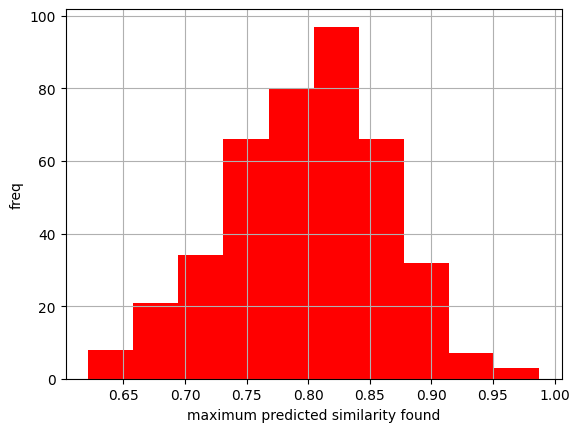

In [591]:
_=plt.hist(max_sim, color='r',bins=10)
plt.xlabel('maximum predicted similarity found')
plt.ylabel('freq')
plt.grid()

Text(0, 0.5, 'frequency')

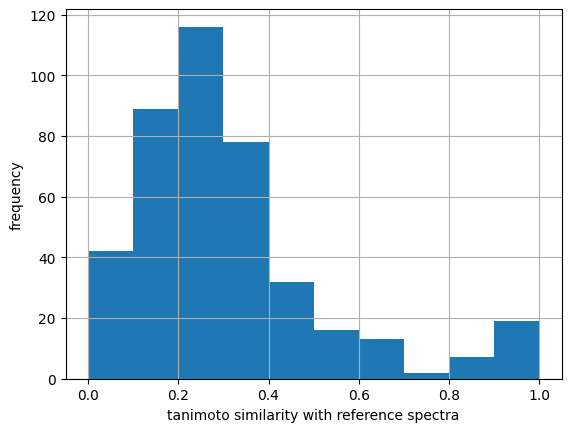

In [592]:
plt.hist(tanimoto_retrieved)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')

In [593]:
tanimoto_retrieved= np.array(tanimoto_retrieved)

Text(0.5, 0, 'tanimoto')

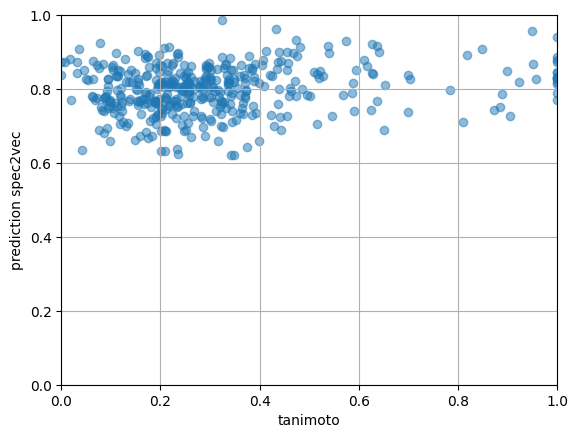

In [594]:
plt.scatter(tanimoto_retrieved, max_sim, alpha=0.5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.ylabel('prediction spec2vec')
plt.xlabel('tanimoto')

## Check which is the spectra that has wrong predictions

In [595]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
def calculate_mcs_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    # Perform MCS (Maximum Common Substructure) search
    mcs = rdFMCS.FindMCS([mol1, mol2])

    # Get SMARTS pattern from MCS result
    mcs_smarts = Chem.MolToSmarts(mcs.queryMol)
    
    # Calculate Tanimoto-like similarity
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)
    #mcs_count = len(Chem.GetMolFrags(mcs_mol))
    mcs_count = mcs_mol.GetNumAtoms()
    similarity = mcs_count / (mol1.GetNumAtoms() + mol2.GetNumAtoms() - mcs_count)

    return similarity, mcs_mol
from rdkit.Chem import rdRascalMCES
def calculate_mces_sim(smiles1, smiles2, similarity_threshold=0.7):

    ad1 = Chem.MolFromSmiles(smiles1)
    ad2 = Chem.MolFromSmiles(smiles2)
    opts = rdRascalMCES.RascalOptions()
    opts.similarityThreshold = similarity_threshold
    opts.returnEmptyMCES = True
    results = rdRascalMCES.FindMCES(ad1, ad2, opts)
    if len(results) != 0:
        similarity_tier1= results[0].tier1Sim
        similarity_tier2= results[0].tier2Sim
    
        if similarity_tier2 != -1:
            return similarity_tier2 #if the lower threshold is not surpassed
        else:
            return similarity_tier1
    else:
        return None

In [596]:
len(all_spectrums_janssen)

414

In [597]:
len(spectrums_retrieved)

414

In [598]:
bad_predictions = np.argsort(abs(tanimoto_retrieved-max_sim))[::-1]

In [599]:
target_spectra=bad_predictions[-2]

In [600]:
max_sim[target_spectra]

0.7965556834837721

In [601]:
tanimoto_retrieved[target_spectra]

0.7832369942196532

In [602]:
## mcs
sim_mcs, mol_mcs=calculate_mcs_similarity(smiles1=all_spectrums_janssen[target_spectra].metadata['smiles'], 
                         smiles2=spectrums_retrieved[target_spectra].metadata['smiles'])
sim_mcs

0.7391304347826086

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>)

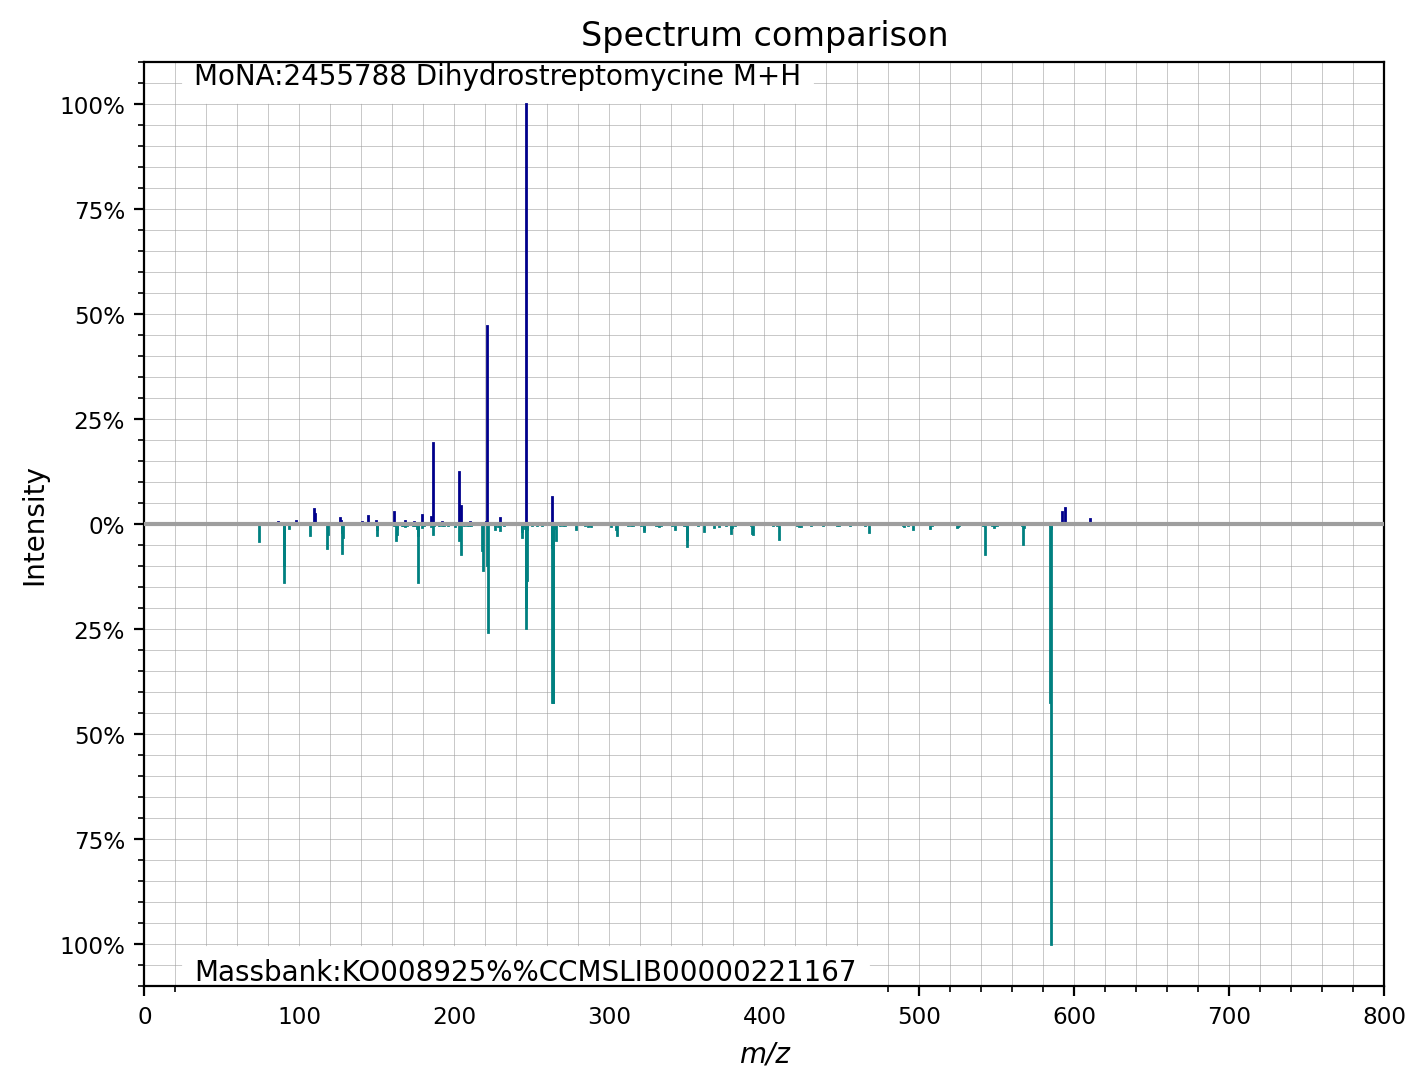

In [603]:
spectrums_retrieved[target_spectra].plot_against(all_spectrums_janssen[target_spectra])
#plt.xlim(0, 100)

In [604]:
sim_mces = calculate_mces_sim(smiles1=all_spectrums_janssen[target_spectra].metadata['smiles'], 
                         smiles2=spectrums_retrieved[target_spectra].metadata['smiles'])
sim_mces

0.9757584770969661

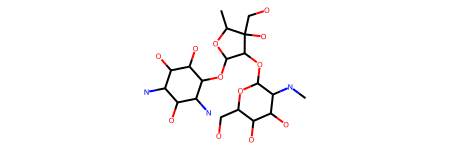

In [605]:
mol_mcs

In [606]:
## plot the molecules

In [607]:
Chem.CanonSmiles(all_spectrums_janssen[target_spectra].metadata['smiles'])

'CNC1C(OC2C(OC3C(O)C(O)C(NC(=N)N)C(O)C3NC(=N)N)OC(C)C2(O)CO)OC(CO)C(O)C1O'

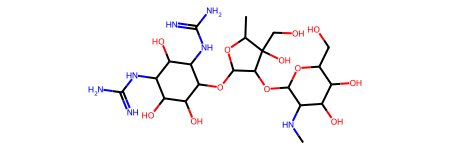

In [608]:
from rdkit import Chem
mol_janssen = Chem.MolFromSmiles(all_spectrums_janssen[target_spectra].metadata['smiles'])
mol_janssen

In [609]:
Chem.CanonSmiles(spectrums_retrieved[target_spectra].metadata['smiles'])

'CN[C@@H]1[C@H](O[C@H]2[C@H](O[C@H]3[C@H](O)[C@@H](O)[C@H](N=C(N)N)[C@@H](O)[C@@H]3N=C(N)N)O[C@@H](C)[C@]2(O)CO)O[C@@H](CO)[C@H](O)[C@H]1O'

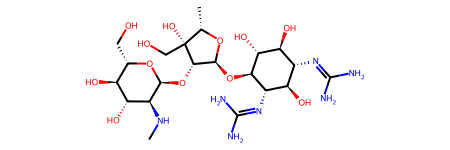

In [610]:
mol_ref = Chem.MolFromSmiles(spectrums_retrieved[target_spectra].metadata['smiles'])
mol_ref

## FIND SIMILARITY BASED ON MCS

In [611]:
len(smiles_retrieved)

414

In [612]:
len(smiles_janssen)

414

In [613]:
mces_sims=[]
for s0,s1 in tqdm(zip(smiles_janssen, smiles_retrieved)):
    similarity= calculate_mces_sim(s0, s1)
    mces_sims.append(similarity)

91it [00:00, 315.47it/s]Too many matching bond pairs (1341) so can't continue.
Too many matching bond pairs (1102) so can't continue.
215it [00:09, 19.34it/s]Too many matching bond pairs (1380) so can't continue.
296it [00:10, 33.15it/s]Too many matching bond pairs (1053) so can't continue.
414it [00:12, 34.00it/s]


In [614]:
# Specify the bin width
bin_width = 0.1

# Calculate the number of bins based on the data range and bin width
bins = np.arange(0, 1 + bin_width, bin_width)

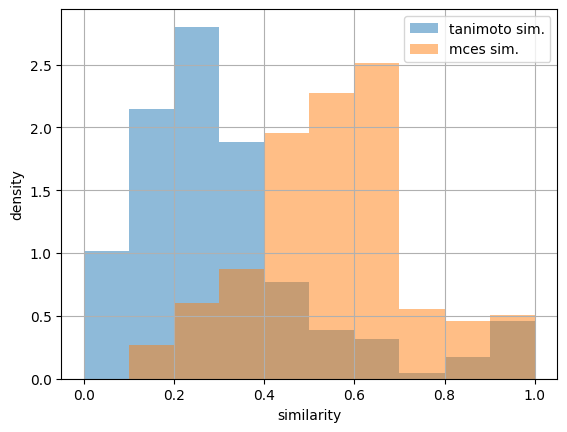

In [615]:
plt.hist(tanimoto_retrieved,alpha=0.5, label='tanimoto sim.', density=True, bins=bins)
plt.hist([m for m in mces_sims if m is not None],alpha=0.5, label='mces sim.', density=True, bins=bins)
plt.xlabel('similarity')
plt.ylabel('density')
plt.legend()
plt.grid()

## saving of results

In [616]:
def get_identifier(s):
    if 'nistno' in s.metadata:
        return(s.metadata['nistno'])
    elif 'spectrum_id' in s.metadata:
        return (s.metadata['spectrum_id'])

In [617]:
all_spectrums_ref_identifiers =[]
for s in all_spectrums_reference:
    ident = get_identifier(s)
    all_spectrums_ref_identifiers.append(ident)

In [618]:
all_spectrums_retrieved_identifiers =[]
for s in spectrums_retrieved:
    ident = get_identifier(s)
    all_spectrums_retrieved_identifiers.append(ident)

In [619]:
original_spectrums_retrieved = [all_spectrums_reference[all_spectrums_ref_identifiers.index(ident)] for s,ident in zip(spectrums_retrieved, all_spectrums_retrieved_identifiers)]

In [620]:
len(original_spectrums_retrieved)

414

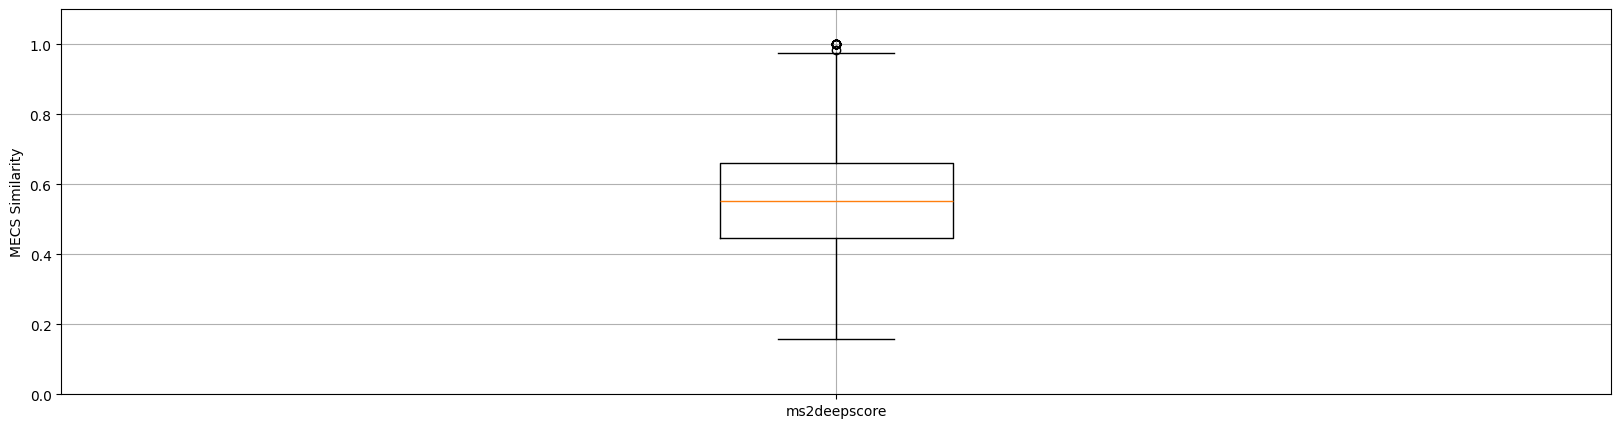

In [621]:
# Create a box plot
sim_list=[]
labels_list=[]
for s in ['ms2deepscore']:
    sim_retrieved= [m for m in mces_sims if m is not None]
    sim_list.append(sim_retrieved)
plt.figure(figsize=(20,5))
plt.boxplot(sim_list, labels=['ms2deepscore'])
#plt.boxplot(, labels=labels_list)

plt.ylim([0,1.1])
plt.ylabel('MECS Similarity')
plt.title('')
plt.grid()

In [622]:
results ={ 'preprocessed_all_spectrums_janssen':preprocessed_all_spectrums_janssen,
          'original_all_spectrums_janssen':all_spectrums_janssen,
            'smiles_janssen':smiles_janssen,
          'smiles_retrieved':smiles_retrieved,
          'spectrums_retrieved':spectrums_retrieved,
          'original_spectrums_retrieved':original_spectrums_retrieved,
            'tanimoto_retrieved':tanimoto_retrieved,
          'max_sim':max_sim,
          'mces_retrieved':mces_sims}

In [623]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_unknwon_compounds.pkl', 'wb') as f:
    dill.dump(results, f)

## check what are the characteristics of the spectrums retrieved

In [624]:
spectrums_retrieved

[Spectrum(precursor m/z=503.13, 157 fragments between 50.0 and 307.0),
 Spectrum(precursor m/z=525.90, 9 fragments between 382.3 and 526.6),
 Spectrum(precursor m/z=233.16, 26 fragments between 51.0 and 120.1),
 Spectrum(precursor m/z=218.11, 39 fragments between 54.0 and 189.1),
 Spectrum(precursor m/z=294.05, 53 fragments between 83.0 and 298.1),
 Spectrum(precursor m/z=281.17, 101 fragments between 56.0 and 263.2),
 Spectrum(precursor m/z=354.12, 69 fragments between 51.0 and 206.0),
 Spectrum(precursor m/z=531.16, 119 fragments between 50.0 and 173.0),
 Spectrum(precursor m/z=342.15, 144 fragments between 51.0 and 174.1),
 Spectrum(precursor m/z=299.05, 21 fragments between 54.0 and 173.0),
 Spectrum(precursor m/z=853.00, 17 fragments between 267.0 and 853.6),
 Spectrum(precursor m/z=313.19, 69 fragments between 51.0 and 159.0),
 Spectrum(precursor m/z=311.17, 7155 fragments between 44.9 and 1505.2),
 Spectrum(precursor m/z=297.08, 112 fragments between 50.0 and 281.1),
 Spectrum(p

In [625]:
spectrums_retrieved[5].metadata

{'charge': 1,
 'ionmode': 'positive',
 'smiles': 'C[N+]1(CCN2C(C1)C3=CC=CC=C3CC4=CC=CC=C42)[O-]',
 'inchi': 'InChI=1S/C18H20N2O/c1-20(21)11-10-19-17-9-5-3-7-15(17)12-14-6-2-4-8-16(14)18(19)13-20/h2-9,18H,10-13H2,1H3',
 'scans': '3452',
 'ms_level': '2',
 'instrument_type': 'LC-ESI-qTof',
 'file_name': 'output_mgf.mgf',
 'peptide_sequence': '*..*',
 'organism_name': 'MONA',
 'compound_name': 'MoNA:800345 1,2,3,4,10,14b-Hexahydro-2-methyldibenzo(c,f)pyrazino(1,2-a)azepine 2-oxide M+H',
 'principal_investigator': 'MoNA',
 'data_collector': 'MoNA',
 'submit_user': 'mwang87',
 'confidence': '3',
 'spectrum_id': 'CCMSLIB00000566200',
 'precursor_mz': 281.165}

In [626]:
bad_indexes= np.argsort(tanimoto_retrieved)[0:20]
good_indexes= [index for index in range(0, len(tanimoto_retrieved)) if index not in bad_indexes]

In [627]:
bad_spectrums=[spectrums_retrieved[index] for index in bad_indexes ]
good_spectrums=[spectrums_retrieved[index] for index in good_indexes ]

In [628]:
is_gnps_bad_spectrums = [s for s in bad_spectrums if 'spectrum_id' in s.metadata]
is_gnps_good_spectrums = [s for s in good_spectrums if 'spectrum_id' in s.metadata]

In [629]:
len(is_gnps_bad_spectrums)/len(bad_spectrums)

0.8

In [630]:
len(is_gnps_good_spectrums)/len(good_spectrums)

0.3629441624365482

## pass the same bad spectrum used in simba here

In [631]:
len(preprocessed_all_spectrums_janssen)

414

In [632]:
len(preprocessed_all_spectrums_reference)

326381

In [633]:
target_spectrum_janssen = [s for s in preprocessed_all_spectrums_janssen if s.metadata['id']=='CUIHSIWYWATEQL'][0]

In [634]:
target_spectrum_janssen

Spectrum(precursor m/z=438.17, 191 fragments between 60.3 and 445.1)

In [635]:
target_spectrum_ref = [s for s in preprocessed_all_spectrums_reference if 'spectrum_id' in s.metadata]
target_spectrum_ref = [s for s in target_spectrum_ref if s.metadata['spectrum_id']=='CCMSLIB00003134614'][0]

In [636]:
target_spectrum_ref

Spectrum(precursor m/z=283.18, 12 fragments between 84.1 and 283.2)

In [637]:
target_results=calculate_scores( [target_spectrum_ref], [target_spectrum_janssen], similarity_model
                    )

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 6ms/step


In [638]:
target_results.scores_by_query(target_spectrum_janssen, name='Spec2Vec', sort=True)

[(Spectrum(precursor m/z=283.18, 12 fragments between 84.1 and 283.2),
  0.489553673045622)]

## what I got when I run the model?

In [639]:
results_scores.scores_by_query(target_spectrum_janssen, name='Spec2Vec', sort=True)

[(Spectrum(precursor m/z=414.15, 39 fragments between 65.0 and 414.2),
  0.7416386974410372),
 (Spectrum(precursor m/z=383.15, 113 fragments between 50.6 and 383.2),
  0.7361647111512287),
 (Spectrum(precursor m/z=330.15, 67 fragments between 50.0 and 173.1),
  0.7208433530345295),
 (Spectrum(precursor m/z=357.20, 177 fragments between 55.1 and 251.1),
  0.7083392894183532),
 (Spectrum(precursor m/z=207.08, 45 fragments between 51.0 and 173.1),
  0.7041835654034623),
 (Spectrum(precursor m/z=204.11, 80 fragments between 56.0 and 204.1),
  0.7040667115430131),
 (Spectrum(precursor m/z=531.27, 173 fragments between 51.0 and 216.1),
  0.7022103942856378),
 (Spectrum(precursor m/z=207.08, 56 fragments between 51.0 and 173.1),
  0.7018906899250693),
 (Spectrum(precursor m/z=376.22, 154 fragments between 51.0 and 319.2),
  0.7013377440138455),
 (Spectrum(precursor m/z=459.09, 117 fragments between 65.0 and 459.1),
  0.697701248230284),
 (Spectrum(precursor m/z=207.08, 54 fragments between 50

In [640]:
spectrums_retrieved

[Spectrum(precursor m/z=503.13, 157 fragments between 50.0 and 307.0),
 Spectrum(precursor m/z=525.90, 9 fragments between 382.3 and 526.6),
 Spectrum(precursor m/z=233.16, 26 fragments between 51.0 and 120.1),
 Spectrum(precursor m/z=218.11, 39 fragments between 54.0 and 189.1),
 Spectrum(precursor m/z=294.05, 53 fragments between 83.0 and 298.1),
 Spectrum(precursor m/z=281.17, 101 fragments between 56.0 and 263.2),
 Spectrum(precursor m/z=354.12, 69 fragments between 51.0 and 206.0),
 Spectrum(precursor m/z=531.16, 119 fragments between 50.0 and 173.0),
 Spectrum(precursor m/z=342.15, 144 fragments between 51.0 and 174.1),
 Spectrum(precursor m/z=299.05, 21 fragments between 54.0 and 173.0),
 Spectrum(precursor m/z=853.00, 17 fragments between 267.0 and 853.6),
 Spectrum(precursor m/z=313.19, 69 fragments between 51.0 and 159.0),
 Spectrum(precursor m/z=311.17, 7155 fragments between 44.9 and 1505.2),
 Spectrum(precursor m/z=297.08, 112 fragments between 50.0 and 281.1),
 Spectrum(p